# DNN: analysis with Keras of 2D data

2023-03-03 18:56:08.118331: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-03 18:56:10.190893: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-03-03 18:56:10.190992: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-03-03 18:56:10.191001: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

2
[-31.60811883 -29.54397214] 0.0
[6.77250291 9.5544703 ] 1.0
[46.45145197 15.31770969] 1.0
[24.89066375 15.35698709] 0.0
[24.77148093 46.13067361] 1.0
[-49.16117021 -39.35556233] 0.0
[-20.12962862  15.64111831] 1.0
[30.98125525 37.21759137] 1.0
[46.46475974 22.36853469] 1.0
[14.24753279 21.74536208] 0.0
data: 4000
train: 3200
Train: 3200 	 Validation: 800


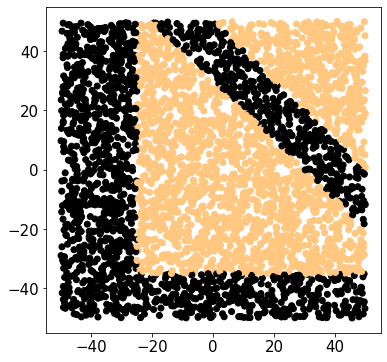

In [1]:
import numpy as np

from keras.models import Sequential
from keras.layers import Dense, Dropout
import keras.optimizers as opt

import matplotlib as mpl
mpl.rc('image', cmap='copper')
import matplotlib.pyplot as plt
# default font
plt.rcParams['font.size'] = 15

%run nonlinear_function.py

# training data
perc_train = 0.8

# Keras works with numpy arrays: just use them from the start
TYPE=1
x = np.loadtxt(filename("data",TYPE), delimiter=' ')
y = np.loadtxt(filename("labels",TYPE), delimiter=' ')
N = len(x)

# dim. of a sample
L = len(x[0])
print(L)

for i in range(10):
    print(x[i],y[i])

N_train = int(perc_train * N)
print(f'data: {N}\ntrain: {N_train}')

plt.figure(figsize = (6,6))
plt.scatter(x[:,0],x[:,1],c=y)
#plt.show()

(x_train, y_train) = (x[0:N_train],y[0:N_train])
(x_valid, y_valid) = (x[N_train:],y[N_train:])
print("Train:",len(x_train),"\t Validation:",len(x_valid))

def Rescale(x):
    #return (x-x.mean())/np.sqrt(x.var())
    return x/50

x_train = Rescale(x_train)
x_valid = Rescale(x_valid)

In [3]:
# reproducibility
np.random.seed(12345)
import tensorflow.random as tf_r
tf_r.set_seed(12345)

CASE=1

jvals=[10**i for i in range(-1, -5, -1)]
optimizers=[opt.Adam, opt.RMSprop, opt.Nadam, opt.Adamax]
rates=[10**i for i in range(-2, -5, -1)]

fits={}

for o in optimizers:
    fits[str(o)]={}
    for r in rates:
        fits[str(o)][str(r)]={}
        for j in jvals:
            print(j)
            model = Sequential()
            model.add(Dense(L,input_shape=(L,),activation='relu'))
            model.add(Dense(20,activation='relu'))
            model.add(Dense(20,activation='relu'))
            model.add(Dense(20,activation='relu'))
            model.add(Dense(20,activation='relu'))
            model.add(Dropout(j))
            model.add(Dense(1,activation='sigmoid'))
            nepoch=400
            #print(model.summary())
            model.compile(loss='binary_crossentropy',
                          optimizer=o(learning_rate=r),
                          metrics=['accuracy'])
            fit = model.fit(x_train, y_train,
                            epochs = nepoch, batch_size = 50,
                            validation_data=(x_valid,y_valid),
                            verbose=0)
            fits[str(o)][str(r)][str(j)]=fit

0.1
0.01
0.001
0.0001
0.1
0.01
0.001
0.0001
0.1
0.01
0.001
0.0001
0.1
0.01
0.001
0.0001
0.1
0.01
0.001
0.0001
0.1
0.01
0.001
0.0001
0.1
0.01
0.001
0.0001
0.1
0.01
0.001
0.0001
0.1
0.01
0.001
0.0001
0.1
0.01
0.001
0.0001
0.1
0.01
0.001
0.0001
0.1
0.01
0.001
0.0001


In [11]:
losses=[[[fits[i][j][k].history['val_loss'][-1] for k in fits[i][j]] for j in fits[i]] for i in fits]
accs=[[[fits[i][j][k].history["val_accuracy"][-1] for k in fits[i][j]] for j in fits[i]] for i in fits]
#print(losses)
m=np.min(losses)
a=np.max(accs)
f=False
for i in range(len(losses)):
    for j in range(len(losses[i])):
        for k in range(len(losses[i][j])):
            if m==losses[i][j][k]:
                print(i,j,k,m)
                f=True
                break
        if f:
            break
    if f:
        break

f=False
for i in range(len(losses)):
    for j in range(len(losses[i])):
        for k in range(len(losses[i][j])):
            if a==accs[i][j][k]:
                print(i,j,k,a)
                f=True
                break
        if f:
            break
    if f:
        break

### best is Nadam, rate 0.01, dropout 0.001

2 0 1 0.017053889110684395
2 1 2 0.9950000047683716


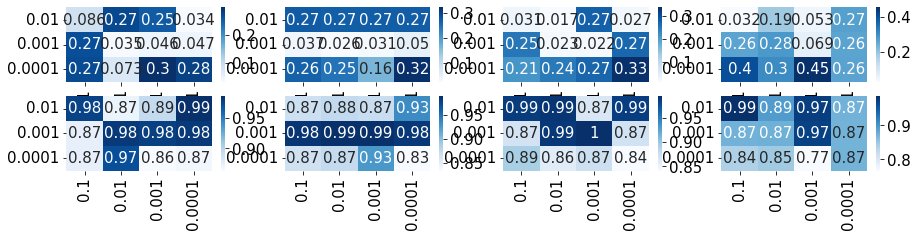

In [12]:
import pandas as pd
import seaborn as sn 
fig, ax = plt.subplots(ncols=len(optimizers), nrows=2, figsize=(15,3) )
c=0
for o in range(len(optimizers)):
    df = pd.DataFrame(losses[o], index = [i for i in rates],
                  columns = [j for j in jvals])
    sn.heatmap(df, annot=True, cmap="Blues", ax=ax[0][o])
    df2 = pd.DataFrame(accs[o], index = [i for i in rates],
                  columns = [j for j in jvals])
    sn.heatmap(df2, annot=True, cmap="Blues", ax=ax[1][o])